In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import seaborn as sns

np.random.seed(0)
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
CMAP = viridis

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def standardize(X, with_mean=True, with_std=True, with_pca=False):
    rescaled = StandardScaler(with_mean=with_mean, with_std=with_std).fit_transform(X)
    if pca:
         return pd.DataFrame(PCA(n_components="mle").fit_transform(rescaled))
    else:
        return pd.DataFrame(rescaled, columns=X.columns)

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, roc_auc_score
from numpy import linspace

def plot_roc(axis, y_true, y_scores):
    cmap = CMAP(linspace(0,1,1))
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    axis.plot(fpr, tpr, lw=2, label=f"ROC AUC: {auc:.2f}", color=cmap[0])
    axis.plot([0,1], [0,1], "k--")
    axis.axis([0, 1, 0, 1])
    axis.set_xlabel("False Positive Rate")
    axis.set_ylabel("True Positive Rate")

def plot_prec_recall(axis, y_true, y_scores):
    cmap = CMAP(linspace(0,1,2))
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    axis.plot(thresholds, precisions[:-1], "--", label="Precision", color=cmap[0])
    axis.plot(thresholds, recalls[:-1], "--", label="Recall", color=cmap[1])
    axis.set_xlabel("Threshold")
    
def plot_confusion_matrix(axis, cm, classes,
                          normalize=False,
                          title='Confusion matrix',):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    axis.imshow(cm, interpolation='nearest', cmap=CMAP)
    tick_marks = np.arange(len(classes))
    axis.set_xticks(tick_marks)
    axis.set_yticks(tick_marks)
    axis.set_xticklabels(classes)
    axis.set_yticklabels(classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axis.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black")

    axis.set_ylabel('True label')
    axis.set_xlabel('Predicted label')
    
def eval_plots(clf, X_train, y_train, method="decision_function"):
    # Set up the axes
    fig, (cm_axis, pr_axis, roc_axis) = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'width_ratios':[2,5,5], "wspace":0.3})
    
    # Make prec-recall curves
    y_scores = cross_val_predict(clf, X_train, y_train, cv=3, method=method)
    
    plot_prec_recall(pr_axis, y_train, y_scores)

    # Make ROC curve
    plot_roc(roc_axis, y_train, y_scores)
    
    #Make confusion matrix
    y_pred = cross_val_predict(clf, X_train, y_train, cv=3)
    plot_confusion_matrix(cm_axis, confusion_matrix(y_train, y_pred), classes="Wg", normalize=True)
    
    plt.legend()

## Load in the data

In [4]:
SIZE = 21
DATA_PATH = "data/{}x{}".format(SIZE, SIZE)

wnames = [f"seed{i}/w_obs" for i in [0,1]]
gnames = [f"seed{i}/g_obs" for i in [0,1,2,3,4]]

columns = ["Nq", "Nq/E", "Emean", "Mj", "g", "B", "M1/2", "e", "eq"]

In [5]:
w = (pd.concat([pd.read_csv(f"{DATA_PATH}/{name}.csv", header=None, dtype=np.float64, names=columns, index_col=False)
                for name in wnames])
        .dropna(1)
    )
w["W?"] = 1
g = (pd.concat([pd.read_csv(f"{DATA_PATH}/{name}.csv", header=None, dtype=np.float64, names=columns, index_col=False)
                for name in gnames])
        .dropna(1)
    )
g["W?"] = 0

data = pd.concat([w, g]).sample(frac=1).reset_index(drop=True)

In [6]:
print("Gluon: {}; W: {};".format(g.shape[0], w.shape[0]))

Gluon: 75991; W: 43972;


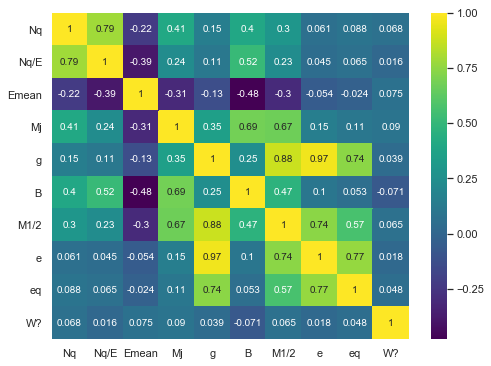

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
sns.heatmap(data.corr(), annot=True, ax=ax, cmap=CMAP)

## Split into test and training sets

In [8]:
from sklearn.model_selection import train_test_split

features = ["Nq", "Emean", "Mj", "B", "M1/2"]

y = data["W?"]
X = standardize(data[features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=0)

## Start with a basic SGD classifier and see how deals with the data

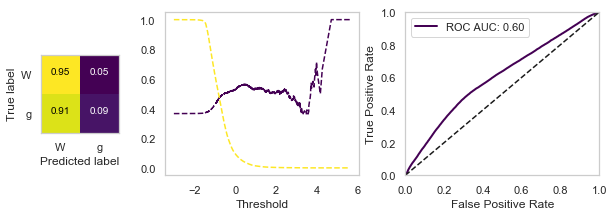

In [14]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(random_state=0, max_iter=5, tol=None)
eval_plots(clf, X_train, y_train)

## Now try a SVM classifier

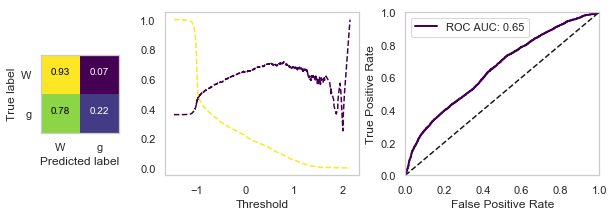

In [15]:
from sklearn.svm import SVC

clf = SVC(random_state=0, gamma='scale')
eval_plots(clf, X_train.iloc[:10000], y_train.iloc[:10000])

## Random forest

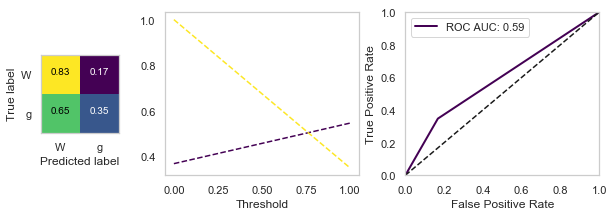

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, n_estimators=10, criterion="gini")
eval_plots(clf, X_train, y_train, method="predict")

## Nearest Neighbors

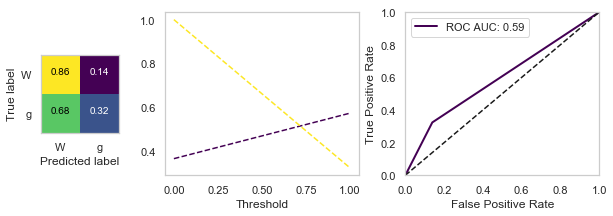

In [17]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=10)
eval_plots(clf, X_train, y_train, method="predict")